# Kalman filter

In [7]:
!pip install pykalman

In [153]:
import numpy as np
import pykalman
from pykalman import KalmanFilter
from new_dataloading import Obs_noise,Model_noise, mask_trainD,  Database
import torch
import matplotlib.pyplot as plt
from netCDF4 import Dataset
ncfile = Dataset('Results/Bestmodel-additive_noise.nc')
print(ncfile)
init = ncfile['inits']
target = ncfile['targets']
mu = ncfile['mean_pred']
X_testD = target[:,:,:]
X_test_obsD = init[:,:,:]
X_test_obsD[:,7:,:] = np.zeros(np.shape(X_test_obsD[:,7:,:]))


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Nb_samples(200), time(10), x(30)
    variables(dimensions): float32 mean_pred(Nb_samples, time, x), float32 cov_pred(Nb_samples, time, x), float32 inits(Nb_samples, time, x), float32 targets(Nb_samples, time, x), float64 Nb_samples(Nb_samples), float64 time(time), float64 space(x)
    groups: 


In [154]:
print(0.8418+0.9337+0.9863+0.6442+0.7820)
print(X_testD[0,:,:])
D = Database[int(0.8*1000):,:,:]
print(D[0,0:5,0].shape)
indt = 8
indx = 5
print((torch.sum(D[0,(indx-1):(indx+2),indt-1])/4)+D[0,indx-2,indt-2]/4+D[0,indx+2,indt-2]/4)
print(D[0,indx,indt])
print(D[0,0:10,:])



4.188000000000001
[[ 0.6059945   0.20582938  0.8723039   0.21842653  0.28814435  0.48572344
   0.16741365  0.9411095   0.70449287  0.7396855   0.20990491  0.7142311
   0.4826386   0.17592639  0.04592639  0.60171264  0.58821714  0.9988715
   0.00801593  0.94195014  0.73048234  0.10921872  0.12198925  0.59345907
   0.5393013   0.97352093  0.8837228   0.14822346  0.51324236  0.8561798 ]
 [ 0.77373755  0.6911531   0.54074925  0.5371529   0.49165815  0.54557794
   0.6655755   0.7448542   0.728063    0.8340989   0.70997554  0.54458374
   0.40752617  0.49755844  0.470522    0.61047786  0.5374112   0.7694646
   0.790109    0.7045444   0.50837827  0.5982676   0.529017    0.59307724
   0.80599624  0.800601    0.77759445  0.8308665   0.7274344   0.6044897 ]
 [ 0.5224596   0.63003534  0.5338007   0.44084972  0.512571    0.51190835
   0.5682353   0.6511823   0.48834878  0.8087091   0.70303375  0.54336685
   0.32546404  0.5973744   0.53579414  0.56389403  0.3095283   0.7149793
   0.7198555   0.65090

In [155]:
print(X_testD.shape)
t = X_testD.shape[1]
x = X_testD.shape[2]
transition_matrices = np.zeros((t-2,2*x,2*x))
A1 = 0.25*(np.eye(x)+np.eye(x, k=-1))
A1[x-1,0]=0.25
transition_matrices[0,:x,:x]= A1
transition_matrices[0,:x,x:]=0.25*(np.eye(x, k=2)+np.eye(x,k=-2)+np.eye(x,k=x-2)+np.eye(x,k=-x+2))
transition_matrices[0,:x,x:]= np.eye(x)
mod = 'fsum1'

if mod == 'fsum1':
    for i in range(1,t-2):
        transition_matrices[i,:x,:x] = A1
        transition_matrices[i,x:,:x] = np.eye(x)
        transition_matrices[i,:x,x:] = 0.25*(np.eye(x,k=-2)+np.eye(x,k=-x+2))
        

        
observation_matrix = np.identity(2*x)

transition_covariance = np.zeros((2*x,2*x))
transition_covariance[:x,:x] = Model_noise**2 * np.identity(x)

observation_covariance = np.zeros((2*x,2*x))
observation_covariance[:x,:x] = Obs_noise**2 * np.identity(x)

x1 = X_test_obsD[0,0,:]
x2 = X_test_obsD[0,1,:]   

Initial_state = np.zeros((2*x))
Initial_state[:x] = x2
Initial_state[x:] = x1
        
Initial_covariance = Model_noise**2 * np.identity(2*x)

(200, 10, 30)


In [156]:
k = KalmanFilter(
    transition_matrices=transition_matrices, 
             observation_matrices=observation_matrix, 
             transition_covariance=transition_covariance, 
             observation_covariance=observation_covariance, 
             transition_offsets=None, 
             observation_offsets=None, 
             initial_state_mean=Initial_state, 
             initial_state_covariance=Initial_covariance, 
             random_state=None, 
             em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean', 'initial_state_covariance'], 
             n_dim_state=None, 
             n_dim_obs=None
)

In [157]:

X_Filter = np.zeros((t-1,2*x))

for i in range(t-1):
    X_Filter[i,:x] = X_test_obsD[0,i+1,:]
    X_Filter[i,x:] = X_test_obsD[0,i,:]

mask = np.zeros((t-1,2*x))

mask[7:,:]+=1
mask[6,:x]+=1

    
X_train_mask = np.ma.masked_array(X_Filter,mask)

KF = k.filter(X_Filter)
print(np.diagonal(KF[1],axis1=1,axis2=2).shape)
print(X_test_obsD[0,1,:])
print(X_testD[0,1,:])


(9, 60)
[0.77377796 0.6924515  0.54071414 0.5368739  0.49018624 0.5448191
 0.66494215 0.74539524 0.7273161  0.8345771  0.70898485 0.5422692
 0.40797788 0.49638635 0.47018865 0.6101672  0.53682137 0.7713329
 0.7911899  0.7049835  0.5088578  0.60001004 0.5301425  0.5920548
 0.80579364 0.8025772  0.7775589  0.8298607  0.72783315 0.6041583 ]
[0.77373755 0.6911531  0.54074925 0.5371529  0.49165815 0.54557794
 0.6655755  0.7448542  0.728063   0.8340989  0.70997554 0.54458374
 0.40752617 0.49755844 0.470522   0.61047786 0.5374112  0.7694646
 0.790109   0.7045444  0.50837827 0.5982676  0.529017   0.59307724
 0.80599624 0.800601   0.77759445 0.8308665  0.7274344  0.6044897 ]


# Prediction with Kalman FIlter for additive noise model

In [158]:
X_preds_KF = np.zeros(X_test_obsD.shape)
X_preds_KF[:,0:2,:] = X_test_obsD[:,0:2,:]
X_cov_KF = np.zeros((X_test_obsD.shape[0],t,x,x))
X_cov_KF[:,0,:] = Obs_noise**2*np.identity(x)
X_cov_KF[:,1,:] = Obs_noise**2*np.identity(x)


for i in range(X_test_obsD.shape[0]):    
    x1 = X_test_obsD[i,0,:]
    x2 = X_test_obsD[i,1,:]   

    Initial_state = np.zeros((2*x))
    Initial_state[:x] = x2
    Initial_state[x:] = x1
    k = KalmanFilter(
    transition_matrices=transition_matrices, 
             observation_matrices=observation_matrix, 
             transition_covariance=transition_covariance, 
             observation_covariance=observation_covariance, 
             transition_offsets=None, 
             observation_offsets=None, 
             initial_state_mean=Initial_state, 
             initial_state_covariance=Initial_covariance, 
             random_state=None, 
             em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean', 'initial_state_covariance'], 
             n_dim_state=None, 
             n_dim_obs=None
)
    
    X_Filter = np.zeros((t-4,2*x))
    for j in range(t-4):
        X_Filter[j,:x] = X_test_obsD[i,j+1,:]
        X_Filter[j,x:] = X_test_obsD[i,j,:]
    KF = k.filter(X_Filter)
    X_preds_KF[i,2:7,:] = KF[0][1:,:x]
    X_cov_KF[i,2:7,:] = KF[1][1:,:x,:x]
    KFb = KF[1][-1,:,:]
    for j in range(7,t):
        KFb = np.dot(np.dot(transition_matrices[j-2,:,:],KFb),transition_matrices[j-2,:,:].T) +transition_covariance
        X_cov_KF[i,j,:,:] = KFb[:x,:x]
        X_preds_KF[i,j,:] = np.dot(transition_matrices[j-2,:x,:x],X_preds_KF[i,j-1,:]) + np.dot(transition_matrices[j-2,:x,x:],X_preds_KF[i,j-2,:])
    

In [159]:
ind=6
print(X_cov_KF[0,ind,:,:])
print(X_cov_KF.shape)
U= np.diagonal(X_cov_KF,axis1 = 2,axis2=3)
print(U.shape)

[[ 9.97506234e-07  2.79917919e-20 -6.90225681e-20 -5.03286323e-20
   5.78600758e-20 -1.42088733e-19  1.57608393e-19 -4.26255088e-20
  -4.71563153e-20  8.39111628e-20 -1.03109081e-19  5.30134088e-20
  -1.85994726e-20  1.69575098e-20 -1.83821748e-20  5.63786481e-20
  -7.77524237e-20  3.36543949e-20 -1.06585712e-19  5.25508785e-20
  -7.27914599e-20  1.06348589e-19  1.33099099e-19 -4.70116411e-21
   7.17097879e-20  1.28365039e-19 -1.87069512e-20  9.57506438e-20
  -7.35179049e-20 -2.86535364e-20]
 [-8.80120172e-21  9.97506234e-07 -1.78313670e-19 -8.34786068e-20
   2.82046840e-20  6.35427344e-20 -1.29735252e-19  8.13574279e-20
   1.11779827e-19 -3.91234056e-22 -8.49204255e-20  4.64219666e-20
   1.62433510e-20 -3.57039354e-20  5.69963249e-20 -3.90983720e-20
   5.07255949e-21 -9.28899461e-20  4.65898377e-20  2.78814619e-20
   1.12893452e-19  4.10827589e-20  2.13172855e-20  1.30307777e-19
  -6.93137405e-20  2.81330392e-19  5.03040911e-20 -1.26557625e-19
   8.16890802e-20 -8.93619759e-20]
 [-1.8

## Visualization

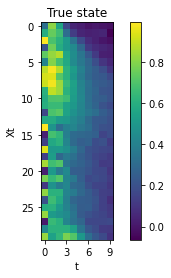

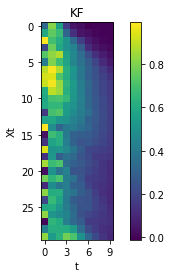

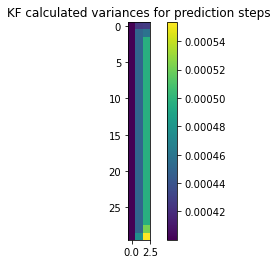

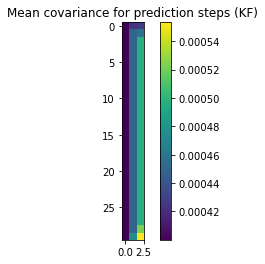

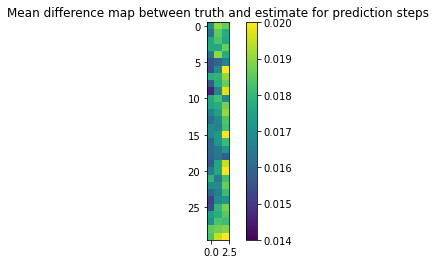

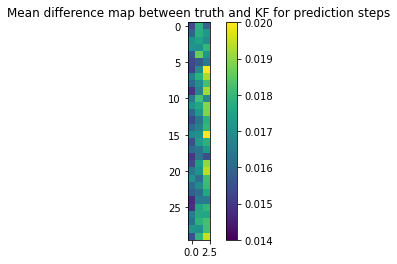

In [160]:
%matplotlib inline
plt.figure
plt.title('True state')
plt.ylabel('Xt')
plt.yticks(np.arange(0,31,5))
plt.xlabel('t')
plt.xticks(np.arange(0,10,3))
plt.imshow(np.transpose(X_testD[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('KF')
plt.ylabel('Xt')
plt.yticks(np.arange(0,31,5))
plt.xlabel('t')
plt.xticks(np.arange(0,10,3))
plt.imshow(np.transpose(X_preds_KF[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('KF calculated variances for prediction steps')
plt.imshow(np.transpose(np.abs(U[10,7:10,:])))
plt.colorbar()
plt.figure()
plt.title('Mean covariance for prediction steps (KF)')
plt.imshow(np.transpose(np.mean(np.abs(U[:,7:10,:]),0)))
plt.colorbar()
plt.figure()
plt.title('Mean difference map between truth and estimate for prediction steps')
plt.imshow(np.transpose(np.mean(np.abs(target[:,7:10,:] - mu[:,7:10,:]),0)),vmin=0.014, vmax=0.02)
plt.colorbar()
plt.figure()
plt.title('Mean difference map between truth and KF for prediction steps')
plt.imshow(np.transpose(np.mean(np.abs(target[:,7:10,:] - X_preds_KF[:,7:10,:]),0)),vmin=0.014, vmax=0.02)
plt.colorbar()

## Forecasts scores

In [52]:
def logarithmic_scores(target,mu,sig):
    return(0.5*(np.dot((np.dot((target-mu).T,np.linalg.inv(sig))),(target-mu)))+0.5*np.log(np.linalg.det(sig))+15*np.log(2*np.pi))


In [53]:
ind = 9
print(logarithmic_scores(X_testD[0,ind,:],X_preds_KF[0,ind,:],X_cov_KF[0,ind,:,:])/30)


-2.108928248184725


# Forecasts with multiplicative noise model

In [172]:
ncfile = Dataset('Results/Input_for_flaginit2.nc')
init = ncfile['inits']
ncfile2 = Dataset('Results/Bestmodel-multiplicative_noise-flagInit2.nc')
target = ncfile['targets']
target2 =ncfile2['targets']
mu = ncfile2['mean_pred']
X_testD = target[:,:,:]
X_test_obsD = init[:,:,:]
X_test_obsD[:,7:,:] = np.zeros(np.shape(X_test_obsD[:,7:,:]))


In [173]:
t = X_testD.shape[1]
x = X_testD.shape[2]
transition_matrices = np.zeros((t-2,2*x,2*x))
A1 = 0.6*np.eye(x)+0.4*np.eye(x, k=-1)
A1[x-1,0]=0.2
transition_matrices[0,:x,:x]= A1
transition_matrices[0,:x,x:]=0.1*np.eye(x, k=2)+0.05*np.eye(x,k=-2)+0.1*np.eye(x,k=-x+2)+0.05*np.eye(x,k=x-2)
transition_matrices[0,x:,x:]= np.eye(x)

mod = 'fsum2'

if mod == 'fsum2':
    for i in range(1,t-2):
        transition_matrices[i,:x,:x] = A1
        transition_matrices[i,x:,:x] = np.eye(x)
        transition_matrices[i,:x,x:] = 0.05*np.eye(x,k=-2)+0.1*np.eye(x,k=-x+2)
        
        
observation_matrix = np.identity(2*x)

x1 = X_test_obsD[0,0,:]
x2 = X_test_obsD[0,1,:]   

Initial_state = np.zeros((2*x))
Initial_state[:x] = x2
Initial_state[x:] = x1
        
Initial_covariance = Model_noise**2 * np.identity(2*x)


observation_covariance = np.zeros((2*x,2*x))
observation_covariance[:x,:x] = Obs_noise**2 * np.identity(x)


### Estimation of model error covariance matrix

In [174]:
Estimated_cov = np.zeros((t-2,x,x))

for i in range(t-2):
    A=np.zeros((D.shape[0],x,x))
    truth = D[:,:,i+2].detach().numpy()
    Estimated = np.dot(D[:,:,i+1],np.transpose(transition_matrices[i,:x,:x]))+np.dot(D[:,:,i],np.transpose(transition_matrices[i,:x,x:]))
    B=Estimated-truth
    B=np.reshape(B,(D.shape[0],x,1))
    for j in range(D.shape[0]):
        A[j,:,:]=np.dot(B[j,:],np.transpose(B[j,:]))
    Estimated_cov[i,:,:]=np.mean(A,axis=0)

In [175]:
print(Estimated_cov[6,:,:])

[[ 5.69751102e-07  2.02272839e-07 -9.79844515e-07 -1.87017007e-06
   1.83620255e-06  2.73236484e-06 -9.92446290e-08  1.47833900e-06
  -2.96054749e-06 -3.74696327e-06  1.11733476e-06 -2.69081494e-06
  -1.42192335e-06 -1.96956228e-06 -1.26862244e-06  4.54717574e-06
   2.29078139e-07  5.23797134e-07  2.22272449e-06 -1.31118068e-07
  -4.99770620e-07  6.18604502e-07 -5.52924155e-08  3.46568121e-06
  -1.88524716e-06  4.31510479e-06  7.66066727e-07 -1.24045461e-06
   9.30634414e-07 -7.75204078e-07]
 [ 2.02272839e-07  2.08027287e-05 -1.29089037e-06  4.48083335e-07
   8.67443250e-06  4.70533130e-06 -3.77360498e-06  1.39951076e-05
   1.04597812e-05  5.86607558e-06 -6.51730296e-06  1.77645102e-05
   1.15227038e-05 -8.07301001e-06 -8.81523534e-06  1.82370892e-05
   3.51564151e-05 -9.85886642e-06  2.35459638e-05  1.05664386e-05
   1.42265032e-05 -1.03586468e-05  2.66200017e-06  2.91381367e-05
  -1.57408086e-05 -1.80219176e-05  1.71415500e-05  3.44038722e-06
   1.85952807e-05 -3.95534189e-06]
 [-9.7

In [176]:
X_preds_KF = np.zeros(X_test_obsD.shape)
X_preds_KF[:,0:2,:] = X_test_obsD[:,0:2,:]
X_cov_KF = np.zeros((X_test_obsD.shape[0],t,x,x))
X_cov_KF[:,0,:] = Obs_noise**2*np.identity(x)
X_cov_KF[:,1,:] = Obs_noise**2*np.identity(x)


for i in range(X_test_obsD.shape[0]): 
    for j in range(t-2):
        if j<(t-5):
            x1 = X_preds_KF[i,j,:]
            x2 = X_preds_KF[i,j+1,:]

            Initial_state = np.zeros((2*x))
            Initial_state[:x] = x2
            Initial_state[x:] = x1
            transition_covariance = np.zeros((2*x,2*x))
            transition_covariance[:x,:x] = Estimated_cov[j,:,:]
            k = KalmanFilter(
    transition_matrices=transition_matrices[j,:,:],
             observation_matrices=observation_matrix, 
             transition_covariance=transition_covariance,
             observation_covariance=observation_covariance, 
             transition_offsets=None, 
             observation_offsets=None, 
             initial_state_mean=Initial_state, 
             initial_state_covariance=Initial_covariance, 
             random_state=None, 
             em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean', 'initial_state_covariance'], 
             n_dim_state=None, 
             n_dim_obs=None
)
    
            X_Filter = np.zeros((2,2*x))
            X_Filter[0,:x] = X_test_obsD[i,j+1,:]
            X_Filter[0,x:] = X_test_obsD[i,j,:]
            X_Filter[1,:x] = X_test_obsD[i,j+2,:]
            X_Filter[1,x:] = X_test_obsD[i,j+1,:]
            KF = k.filter(X_Filter)
            X_preds_KF[i,j+2,:] = KF[0][1,:x]
            X_cov_KF[i,j+2,:,:] = KF[1][1,:x,:x]
            
        else:
            KFb =  np.zeros((2*x,2*x))
            KFb[:x,:x] = X_cov_KF[i,j+1,:,:]
            Stimated = np.zeros((2*x,2*x))
            Stimated[:x,:x] = Estimated_cov[j,:,:]
            KFb = np.dot(np.dot(transition_matrices[j,:,:],KFb),transition_matrices[j,:,:].T) +Stimated
            X_cov_KF[i,j+2,:,:] = KFb[:x,:x]
            X_preds_KF[i,j+2,:] = np.dot(transition_matrices[j,:x,:x],X_preds_KF[i,j+1,:]) + np.dot(transition_matrices[j,:x,x:],X_preds_KF[i,j,:])
        if i ==0:
            print(X_preds_KF[0,:,:])

[[0.25708708 0.08771604 0.62379819 0.86149561 0.39103213 0.31089982
  0.98209536 0.50021482 0.99916464 0.16161819 0.96257365 0.93460661
  0.08283743 0.29818961 0.52435732 0.97960716 0.57575417 0.99280614
  0.38389868 0.23721406 0.97029752 0.20112164 0.53560263 0.32642096
  0.2257759  0.1329212  0.91251034 0.48905256 0.04285233 0.55466974]
 [0.45044842 0.38862202 0.64329338 0.84561831 0.75341314 0.60523456
  0.89953303 0.99767637 1.00279975 0.79570431 0.90497267 0.9283005
  0.61253959 0.46767575 0.68124223 1.05509996 0.96327084 1.00080109
  0.80413932 0.55143243 0.76637739 0.70636636 0.51868331 0.47711167
  0.4146674  0.41507345 0.70770246 0.75552851 0.39643937 0.43067223]
 [0.34500993 0.51436456 0.62252154 0.8547066  0.88678517 0.74591689
  0.9239675  0.96120873 1.16131847 1.01367718 0.94776149 0.96216244
  0.83301983 0.65234981 0.65751677 0.97936038 1.08219352 1.15409226
  1.03969351 0.6714608  0.76223699 0.76857636 0.68862209 0.51624339
  0.58124826 0.46141982 0.61145761 0.81792269 0

In [177]:
ind=7
print(np.dot(transition_matrices[ind,:x,:x],X_preds_KF[0,ind-1,:],)+ np.dot(transition_matrices[ind,:x,x:],X_preds_KF[i,ind-2,:]))
print(X_testD[0,ind,:])
print(X_preds_KF[0,ind,:])
print(X_cov_KF[0,ind,:,:])

[0.03160775 0.14102137 0.33263316 0.56424331 0.7753389  0.97978272
 1.10553281 1.19833783 1.18598354 1.2153631  1.26847842 1.24704936
 1.26064607 1.22923162 1.11908202 0.99223068 0.98115774 1.1015415
 1.21526263 1.25006925 1.1558757  0.99897902 0.91522243 0.84082175
 0.78711708 0.70825575 0.63052867 0.67298435 0.79630942 1.03338978]
[0.03112466 0.1439736  0.3396292  0.56960475 0.7222678  0.9376278
 1.1474216  1.1705021  1.1054006  1.1630273  1.2030038  1.2891203
 1.3094742  1.2527072  1.1741571  0.9768099  1.0366133  1.067545
 1.2383708  1.2515413  1.1616248  1.0103753  0.949213   0.81583387
 0.8395429  0.67911285 0.61674196 0.6585691  0.7590562  0.9487281 ]
[0.03160775 0.14102137 0.3319813  0.55941846 0.76264447 0.95666775
 1.09159545 1.18518242 1.1742302  1.20973602 1.2769625  1.26041235
 1.27107498 1.24255053 1.14492687 1.01629061 1.00629464 1.11899045
 1.24207351 1.28216392 1.19203766 1.02686303 0.93915301 0.86017571
 0.80835329 0.72441066 0.63314909 0.66833255 0.78560993 1.0224605

In [178]:
scores = np.zeros((D.shape[0],t))

for i in range(D.shape[0]):
    for j in range(t):
        scores[i,j] = logarithmic_scores(X_testD[i,j,:],X_preds_KF[i,j,:],X_cov_KF[i,j,:,:])/30
        


In [179]:
print(np.var(scores,axis=0))
print(np.mean(scores,axis=0))

[0.0166282  0.01756802 0.0170714  0.01611398 0.02052644 0.01580418
 0.01686819 0.04774556 0.03845409 0.04041597]
[-5.50210231 -5.48696482 -5.49149568 -5.49966273 -5.48047372 -5.5063477
 -5.50307913 -2.04270127 -1.87135807 -1.79338643]


## Visualization

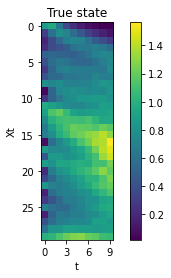

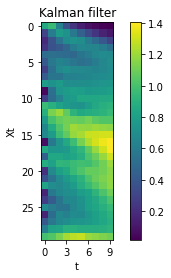

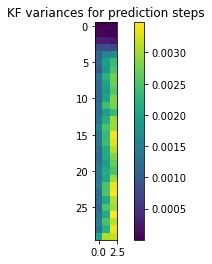

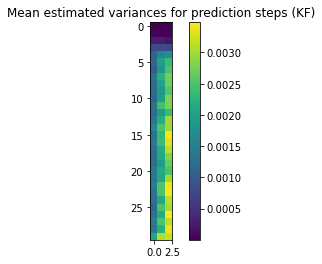

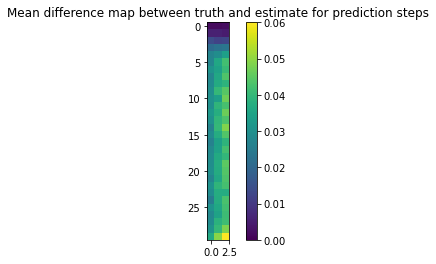

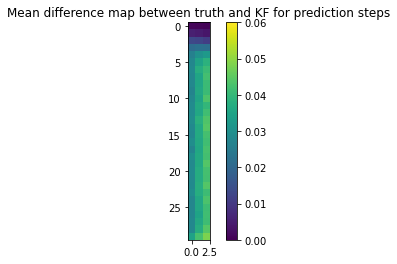

In [180]:
U= np.diagonal(X_cov_KF,axis1 = 2,axis2=3)
%matplotlib inline
plt.figure
plt.title('True state')
plt.ylabel('Xt')
plt.yticks(np.arange(0,31,5))
plt.xlabel('t')
plt.xticks(np.arange(0,10,3))
plt.imshow(np.transpose(X_testD[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('Kalman filter')
plt.ylabel('Xt')
plt.yticks(np.arange(0,31,5))
plt.xlabel('t')
plt.xticks(np.arange(0,10,3))
plt.imshow(np.transpose(X_preds_KF[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('KF variances for prediction steps')
plt.imshow(np.transpose(np.abs(U[10,7:10,:])))
plt.colorbar()
plt.figure()
plt.title('Mean estimated variances for prediction steps (KF)')
plt.imshow(np.transpose(np.mean(np.abs(U[:,7:10,:]),0)))
plt.colorbar()
plt.figure()
plt.title('Mean difference map between truth and estimate for prediction steps')
plt.imshow(np.transpose(np.mean(np.abs(target2[:,7:10,:] - mu[:,7:10,:]),0)),vmin=0,vmax=0.06)
plt.colorbar()
plt.figure()
plt.title('Mean difference map between truth and KF for prediction steps')
plt.imshow(np.transpose(np.mean(np.abs(target[:,7:10,:] - X_preds_KF[:,7:10,:]),0)),vmin=0, vmax=0.06)
plt.colorbar()

### Best Kalman model with multiplicative noise

In [147]:
X_preds_KF = np.zeros(X_test_obsD.shape)
X_preds_KF[:,0:2,:] = X_test_obsD[:,0:2,:]
X_cov_KF = np.zeros((X_test_obsD.shape[0],t,x,x))
X_cov_KF[:,0,:] = Obs_noise**2*np.identity(x)
X_cov_KF[:,1,:] = Obs_noise**2*np.identity(x)


for i in range(X_test_obsD.shape[0]): 
    for j in range(t-2):        
        if j<(t-5):
            x1 = X_preds_KF[i,j,:]
            x2 = X_preds_KF[i,j+1,:]

            Initial_state = np.zeros((2*x))
            Initial_state[:x] = x2
            Initial_state[x:] = x1
            transition_covariance = np.zeros((2*x,2*x))
            Y=np.roll(X_testD[i,j+1,:],1)
            Y[0] =0
            transition_covariance[:x,:x] = (Model_noise*np.diagflat(np.abs(X_testD[i,j+1,:]+Y)))**2
            k = KalmanFilter(
    transition_matrices=transition_matrices[j,:,:],
             observation_matrices=observation_matrix, 
             transition_covariance=transition_covariance,
             observation_covariance=observation_covariance, 
             transition_offsets=None, 
             observation_offsets=None, 
             initial_state_mean=Initial_state, 
             initial_state_covariance=Initial_covariance, 
             random_state=None, 
             em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean', 'initial_state_covariance'], 
             n_dim_state=None, 
             n_dim_obs=None
)
    
            X_Filter = np.zeros((2,2*x))
            X_Filter[0,:x] = X_test_obsD[i,j+1,:]
            X_Filter[0,x:] = X_test_obsD[i,j,:]
            X_Filter[1,:x] = X_test_obsD[i,j+2,:]
            X_Filter[1,x:] = X_test_obsD[i,j+1,:]
            KF = k.filter(X_Filter)
            X_preds_KF[i,j+2,:] = KF[0][1,:x]
            X_cov_KF[i,j+2,:,:] = KF[1][1,:x,:x]
            
        else:
            transition_covariance = np.zeros((2*x,2*x))
            Y=np.roll(X_testD[i,j+1,:],1)
            Y[0] =0
            transition_covariance[:x,:x] = (Model_noise*np.diagflat(np.abs(X_testD[i,j+1,:]+Y)))**2
            KFb =  np.zeros((2*x,2*x))
            KFb[:x,:x] = X_cov_KF[i,j+1,:,:]
            KFb = np.dot(np.dot(transition_matrices[j,:,:],KFb),transition_matrices[j,:,:].T) +transition_covariance
            X_cov_KF[i,j+2,:,:] = KFb[:x,:x]
            X_preds_KF[i,j+2,:] = np.dot(transition_matrices[j,:x,:x],X_preds_KF[i,j+1,:]) + np.dot(transition_matrices[j,:x,x:],X_preds_KF[i,j,:])


In [148]:

ind=9
print(np.dot(transition_matrices[ind-2,:x,:x],X_preds_KF[0,ind-1,:],)+ np.dot(transition_matrices[ind-2,:x,x:],X_preds_KF[i,ind-2,:]))
print(X_testD[0,ind,:])
print(X_preds_KF[0,ind,5])
print(X_cov_KF[0,ind,5,5])

[0.00689404 0.04672099 0.1394531  0.27377515 0.4250268  0.58937781
 0.77950469 1.00515399 1.26263463 1.46406992 1.50354862 1.39797662
 1.25890422 1.18516069 1.19348293 1.26100012 1.3614352  1.43170048
 1.46373189 1.46085806 1.38503925 1.20994088 1.01958855 0.9494907
 1.00498092 1.06952992 1.04180947 0.90724084 0.75654859 0.71630988]
[0.00676879 0.04697492 0.14595018 0.29071152 0.42445448 0.5713565
 0.6877215  0.9409329  1.1393412  1.4389098  1.5147674  1.4847792
 1.3236861  1.2800369  1.2506953  1.1637441  1.4232827  1.4869972
 1.5378402  1.305888   1.3999728  1.3053082  0.9768551  0.9231961
 0.9254665  1.1260247  1.0994358  0.9507809  0.74145967 0.708458  ]
0.5736624739682146
0.0008119120151658348


In [149]:
scores = np.zeros((D.shape[0],t))

for i in range(D.shape[0]):
    for j in range(t):
        scores[i,j] = logarithmic_scores(X_testD[i,j,:],X_preds_KF[i,j,:],X_cov_KF[i,j,:,:])/30
        if np.isnan(scores[i,j]):
            print(np.linalg.det(X_cov_KF[i,j,:,:]))
            print(X_cov_KF[i,j,:10,:10])
    
print(scores)

[[-5.23528584 -5.57366306 -5.62277654 ... -2.04211905 -1.7600141
  -1.82793236]
 [-5.34678067 -5.60726344 -5.58440205 ... -2.21962513 -2.06621916
  -1.92317158]
 [-5.32650082 -5.20615443 -5.58682414 ... -2.20554599 -1.77381661
  -1.53116805]
 ...
 [-5.5590905  -5.35450756 -5.24697565 ... -2.01772874 -1.92110682
  -1.87918846]
 [-5.3690465  -5.54617143 -5.44006277 ... -2.30952844 -2.09326047
  -1.89928623]
 [-5.58381067 -5.36252155 -5.568233   ... -2.30974127 -2.09071593
  -1.94071916]]


In [150]:
print(np.var(scores,axis=0))
print(np.mean(scores,axis=0))

[0.01613718 0.01620077 0.01556815 0.01553306 0.01860283 0.01605794
 0.01531504 0.03078648 0.02909483 0.03657292]
[-5.48979299 -5.49900822 -5.49171591 -5.48788781 -5.47818089 -5.49881213
 -5.48699906 -2.14298091 -1.94543292 -1.88148103]
